In [1]:
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC  
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
import time
import matplotlib.pyplot as plt
import os
import gzip


# DATA LOADING AND PREPROCESSING


In [2]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist("Contents", kind='train')
X_test, y_test = load_mnist("Contents", kind='t10k')
m_train = X_train.shape[0]
m_test = X_test.shape[0]

In [4]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000


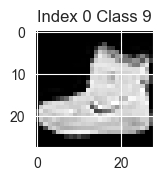

In [5]:
np.random.seed(0)
for i in range(1):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[0].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(0, y_train[0]))
    plt.tight_layout()

In [6]:
# Set random seed for reproducibility
np.random.seed(0)

# Get one image from training set and reshape to 28x28
img = X_train[0].reshape(28, 28)

# Print the pixel matrix
print("Pixel matrix of the image (28x28 size):")
print("Each number represents pixel intensity (0-255):")
print()

# Format output for better readability
for i in range(28):
    for j in range(28):
        # Print each pixel value with fixed width of 3 characters
        print(f"{int(img[i,j]):3d}", end=" ")
    print()  # New line after each row


Pixel matrix of the image (28x28 size):
Each number represents pixel intensity (0-255):

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3 
  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15 
  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66 
  0   0

In [7]:
# normalize and reshape the predictors  
X_train = X_train / 255
X_test = X_test / 255

In [8]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

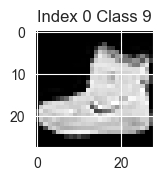

In [9]:
np.random.seed(0)
for i in range(1):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[0].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(0, y_train[0]))
    plt.tight_layout()

In [10]:
# Get one image from training set and reshape to 28x28
img = X_train[0].reshape(28, 28)

# Format output to match the desired display
for i in range(28):
    for j in range(28):
        # Print each value with 5 spaces alignment and 3 decimal places
        print(f"{img[i,j]:5.3f}", end=" ")
    print()  # New line after each row

0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.004 0.000 0.000 0.051 0.286 0.000 0.000 0.004 0.016 0.000 0.000 0.000 0.000 0.004 0.004 0.000 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.012 0.000 0.141 0.533 0.498 0.243 0.212 0.000 0.000 0.000 0.004 0.012 0.016 0.000 0.000 0.012 
0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.024 0.000 0.400 0.800 0.690 0.525 0.565 0.482 0.090 0.000 0.000 0.000 0.000 0.047

# MODEL TRAINING AND EVALUATION

### LINEAR SVC

In [12]:
# Initializing linearSVC
linear_svc = LinearSVC(random_state=42, dual='auto') 
# Fitting model
linear_svc.fit(X_train, y_train)

y_pred_linear = linear_svc.predict(X_test)
# Predicting
accuracy_linear = accuracy_score(y_test, y_pred_linear)

In [13]:
accuracy_linear

0.8402

### RBF KERNEL SVM WITH NYSTROEM APPROXIMATION

In [14]:
# Creating pipeline
nystroem = Nystroem(kernel='rbf',
                    random_state=42, 
                    n_components=100)

pipeline = Pipeline([
    ('nystroem', nystroem),
    ('linear_svc', LinearSVC(dual='auto', random_state=42))
])

# Fitting model
pipeline.fit(X_train, y_train)
accuracy_rbf = pipeline.score(X_test, y_test)
y_pred_rbf = pipeline.predict(X_test)

In [15]:
accuracy_rbf

0.8226

### CLASSIFICATION REPORT AND COMPARISON

In [16]:
print("\nLinear SVM Test Classification Report:")
print(classification_report(y_test, y_pred_linear))


Linear SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.73      0.72      1000
           3       0.82      0.86      0.84      1000
           4       0.72      0.78      0.75      1000
           5       0.94      0.92      0.93      1000
           6       0.65      0.51      0.57      1000
           7       0.91      0.94      0.92      1000
           8       0.92      0.94      0.93      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [17]:
print("\nRBF SVM Test Classification Report:")
print(classification_report(y_test, y_pred_rbf))


RBF SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.98      0.95      0.96      1000
           2       0.71      0.71      0.71      1000
           3       0.81      0.87      0.84      1000
           4       0.70      0.76      0.73      1000
           5       0.91      0.90      0.91      1000
           6       0.61      0.45      0.52      1000
           7       0.89      0.89      0.89      1000
           8       0.91      0.94      0.93      1000
           9       0.91      0.94      0.92      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Training Linear SVM...

Training RBF Kernel (Nystroem) SVM...

Performance Comparison:
                   Model  Training Time  Prediction Time  Accuracy  Total Time
0             Linear SVM        73.4450            0.019    0.8402     73.4641
1  RBF Kernel (Nystroem)        10.7809            0.074    0.8226     10.8549


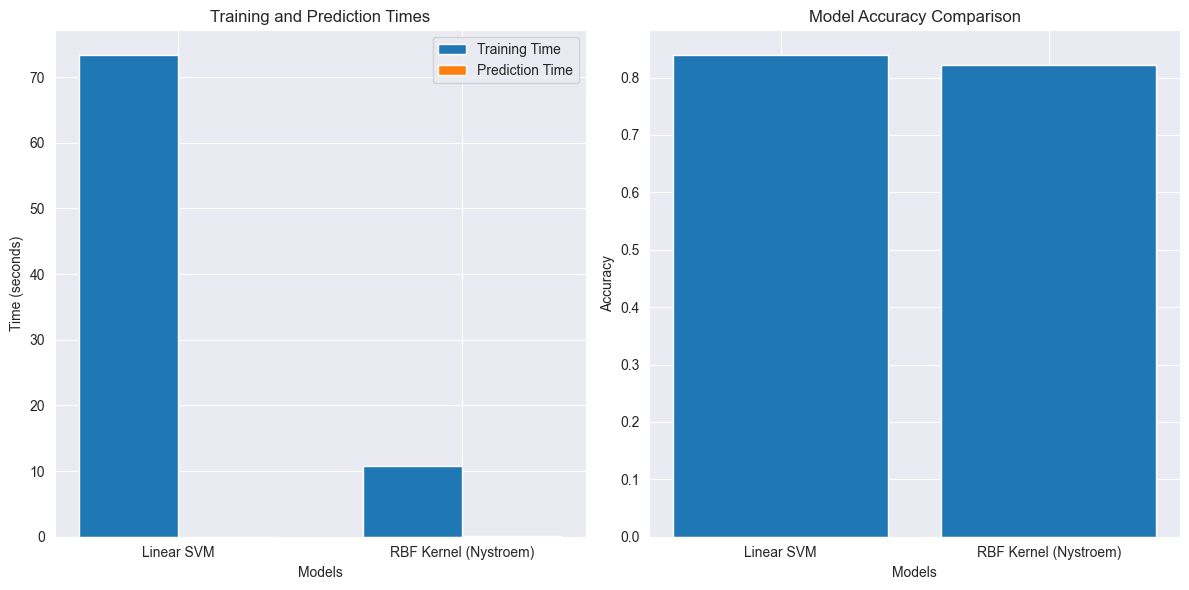


Detailed Analysis:
--------------------------------------------------
Linear SVM:
- Training Time: 73.4450 seconds
- Prediction Time: 0.0190 seconds
- Accuracy: 0.8402
- Samples processed per second during prediction: 525483.47

RBF Kernel (Nystroem):
- Training Time: 10.7809 seconds
- Prediction Time: 0.0740 seconds
- Accuracy: 0.8226
- Samples processed per second during prediction: 135186.75

Relative Performance:
Training time ratio (RBF/Linear): 0.15x
Prediction time ratio (RBF/Linear): 3.89x


In [18]:
timing_results = {
    'Model': [],
    'Training Time': [],
    'Prediction Time': [],
    'Accuracy': []
}

# 1. Linear SVM
print("Training Linear SVM...")
# Start counting
start_time = time.time()
linear_svc = LinearSVC(random_state=42, dual='auto')
linear_svc.fit(X_train, y_train)
# End counting
train_time_linear = time.time() - start_time

# Calculating predicting time
start_time = time.time()
y_pred_linear = linear_svc.predict(X_test)
predict_time_linear = time.time() - start_time

# Saving result
timing_results['Model'].append('Linear SVM')
timing_results['Training Time'].append(train_time_linear)
timing_results['Prediction Time'].append(predict_time_linear)
timing_results['Accuracy'].append(accuracy_score(y_test, y_pred_linear))

# 2. RBF Kernel (Nystroem + LinearSVC)
print("\nTraining RBF Kernel (Nystroem) SVM...")
# Start counting
start_time = time.time()
pipeline.fit(X_train, y_train)
# End counting
train_time_rbf = time.time() - start_time

# Calculating time for prediction
start_time = time.time()
y_pred_rbf = pipeline.predict(X_test)
predict_time_rbf = time.time() - start_time

# Saving result
timing_results['Model'].append('RBF Kernel (Nystroem)')
timing_results['Training Time'].append(train_time_rbf)
timing_results['Prediction Time'].append(predict_time_rbf)
timing_results['Accuracy'].append(accuracy_score(y_test, y_pred_rbf))

# Creating dataframe for the result
timing_df = pd.DataFrame(timing_results)
timing_df['Total Time'] = timing_df['Training Time'] + timing_df['Prediction Time']

print("\nPerformance Comparison:")
print(timing_df.round(4))

# Visualization of the result
plt.figure(figsize=(12, 6))

# 1. Bar plot for running time
plt.subplot(1, 2, 1)
x = np.arange(len(timing_df['Model']))
width = 0.35

plt.bar(x - width/2, timing_df['Training Time'], width, label='Training Time')
plt.bar(x + width/2, timing_df['Prediction Time'], width, label='Prediction Time')

plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Training and Prediction Times')
plt.xticks(x, timing_df['Model'])
plt.legend()

# 2. Bar plot for accuracy
plt.subplot(1, 2, 2)
plt.bar(timing_df['Model'], timing_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print("-" * 50)
print(f"Linear SVM:")
print(f"- Training Time: {train_time_linear:.4f} seconds")
print(f"- Prediction Time: {predict_time_linear:.4f} seconds")
print(f"- Accuracy: {timing_df['Accuracy'][0]:.4f}")
print(f"- Samples processed per second during prediction: {len(X_test)/predict_time_linear:.2f}")

print(f"\nRBF Kernel (Nystroem):")
print(f"- Training Time: {train_time_rbf:.4f} seconds")
print(f"- Prediction Time: {predict_time_rbf:.4f} seconds")
print(f"- Accuracy: {timing_df['Accuracy'][1]:.4f}")
print(f"- Samples processed per second during prediction: {len(X_test)/predict_time_rbf:.2f}")

# Calculate relative performance metrics
speedup_training = train_time_rbf / train_time_linear
speedup_prediction = predict_time_rbf / predict_time_linear

print("\nRelative Performance:")
print(f"Training time ratio (RBF/Linear): {speedup_training:.2f}x")
print(f"Prediction time ratio (RBF/Linear): {speedup_prediction:.2f}x")

# DIMENSIONALITY REDUCTION WITH PCA AND LDA 

### PERFORMED ON LINEAR SVM


Training LinearSVC on original data...

Applying PCA...
Explained variance ratio sum: 0.9123

Training LinearSVC on PCA transformed data...

Applying LDA...

Training LinearSVC on LDA transformed data...

Performance Comparison:
                     Model  Training Time  Prediction Time  Accuracy  \
0  Original (784 features)        83.8529           0.0197    0.8402   
1     PCA (100 components)        22.5744           0.0050    0.8359   
2       LDA (9 components)        11.7030           0.0020    0.8169   

   Total Time  
0     83.8726  
1     22.5794  
2     11.7050  


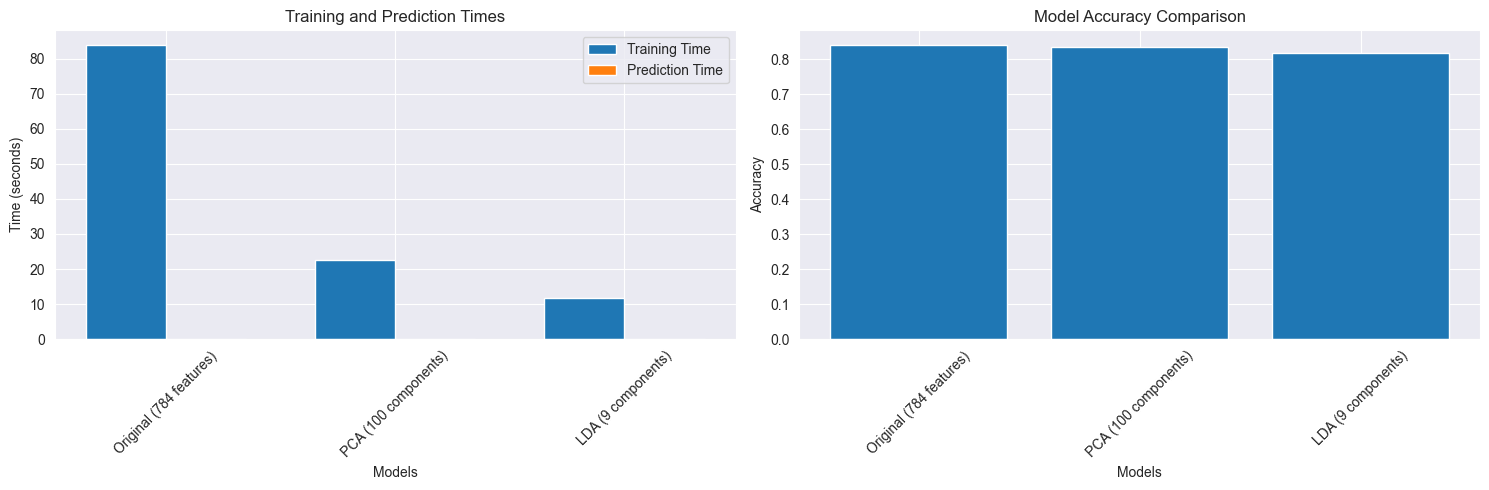

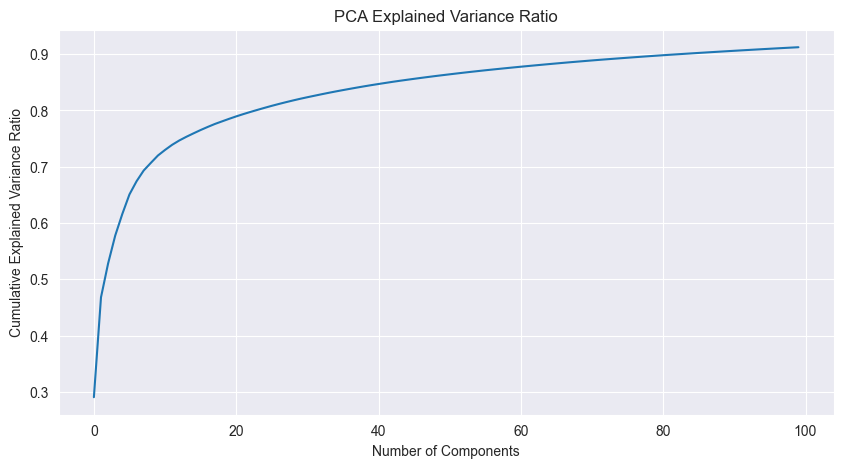


Detailed Analysis:
--------------------------------------------------

Original (784 features):
- Training Time: 83.8529 seconds
- Prediction Time: 0.0197 seconds
- Total Time: 83.8726 seconds
- Accuracy: 0.8402

PCA (100 components):
- Training Time: 22.5744 seconds
- Prediction Time: 0.0050 seconds
- Total Time: 22.5794 seconds
- Accuracy: 0.8359

LDA (9 components):
- Training Time: 11.7030 seconds
- Prediction Time: 0.0020 seconds
- Total Time: 11.7050 seconds
- Accuracy: 0.8169

PCA Additional Information:
- Number of components: 100
- Explained variance ratio sum: 0.9123
- Original dimensionality: 784
- Reduced dimensionality: 100

LDA Additional Information:
- Number of components: 9
- Original dimensionality: 784
- Reduced dimensionality: 9

Classification Reports:

Original Data:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.73   

In [19]:


# Presetting the number of components
n_components_pca = 100
n_components_lda = 9  # LDA defined by max(classes) - 1

results = {
    'Model': [],
    'Training Time': [],
    'Prediction Time': [],
    'Accuracy': []
}

# 1. Original data with LinearSVC
print("\nTraining LinearSVC on original data...")
start_time = time.time()
linear_svc_original = LinearSVC(random_state=42, dual='auto')
linear_svc_original.fit(X_train, y_train)
train_time_original = time.time() - start_time

start_time = time.time()
y_pred_original = linear_svc_original.predict(X_test)
predict_time_original = time.time() - start_time

results['Model'].append('Original (784 features)')
results['Training Time'].append(train_time_original)
results['Prediction Time'].append(predict_time_original)
results['Accuracy'].append(accuracy_score(y_test, y_pred_original))

# 2. PCA with LinearSVC
print("\nApplying PCA...")
start_time = time.time()
pca = PCA(n_components=n_components_pca)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca_transform_time = time.time() - start_time

print(f"Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.4f}")

print("\nTraining LinearSVC on PCA transformed data...")
start_time = time.time()
linear_svc_pca = LinearSVC(random_state=42, dual='auto')
linear_svc_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time

start_time = time.time()
y_pred_pca = linear_svc_pca.predict(X_test_pca)
predict_time_pca = time.time() - start_time

results['Model'].append(f'PCA ({n_components_pca} components)')
results['Training Time'].append(train_time_pca + pca_transform_time)
results['Prediction Time'].append(predict_time_pca)
results['Accuracy'].append(accuracy_score(y_test, y_pred_pca))

# 3. LDA with LinearSVC
print("\nApplying LDA...")
start_time = time.time()
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
lda_transform_time = time.time() - start_time

print("\nTraining LinearSVC on LDA transformed data...")
start_time = time.time()
linear_svc_lda = LinearSVC(random_state=42, dual='auto')
linear_svc_lda.fit(X_train_lda, y_train)
train_time_lda = time.time() - start_time

start_time = time.time()
y_pred_lda = linear_svc_lda.predict(X_test_lda)
predict_time_lda = time.time() - start_time

results['Model'].append(f'LDA ({n_components_lda} components)')
results['Training Time'].append(train_time_lda + lda_transform_time)
results['Prediction Time'].append(predict_time_lda)
results['Accuracy'].append(accuracy_score(y_test, y_pred_lda))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['Total Time'] = results_df['Training Time'] + results_df['Prediction Time']

# Print results
print("\nPerformance Comparison:")
print(results_df.round(4))

# Visualization
plt.figure(figsize=(15, 5))

# 1. Time comparison
plt.subplot(1, 2, 1)
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, results_df['Training Time'], width, label='Training Time')
plt.bar(x + width/2, results_df['Prediction Time'], width, label='Prediction Time')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Training and Prediction Times')
plt.xticks(x, models, rotation=45)
plt.legend()

# 2. Accuracy comparison
plt.subplot(1, 2, 2)
plt.bar(models, results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot PCA explained variance ratio
plt.figure(figsize=(10, 5))
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print("-" * 50)
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"- Training Time: {row['Training Time']:.4f} seconds")
    print(f"- Prediction Time: {row['Prediction Time']:.4f} seconds")
    print(f"- Total Time: {row['Total Time']:.4f} seconds")
    print(f"- Accuracy: {row['Accuracy']:.4f}")

# For PCA specifically
print("\nPCA Additional Information:")
print(f"- Number of components: {n_components_pca}")
print(f"- Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"- Original dimensionality: {X_train.shape[1]}")
print(f"- Reduced dimensionality: {X_train_pca.shape[1]}")

# For LDA specifically
print("\nLDA Additional Information:")
print(f"- Number of components: {n_components_lda}")
print(f"- Original dimensionality: {X_train.shape[1]}")
print(f"- Reduced dimensionality: {X_train_lda.shape[1]}")

# Classification Reports
print("\nClassification Reports:")
print("\nOriginal Data:")
print(classification_report(y_test, y_pred_original))

print("\nPCA Transformed Data:")
print(classification_report(y_test, y_pred_pca))

print("\nLDA Transformed Data:")
print(classification_report(y_test, y_pred_lda))

### PERFORMED ON RBF KERNEL WITH NYSTROEM APPROXIMATION


Training RBF Kernel SVM on original data...

Applying PCA...

Training RBF Kernel SVM on PCA transformed data...

Applying LDA...

Training RBF Kernel SVM on LDA transformed data...

Performance Comparison:
            Model  Training Time  Prediction Time  Accuracy  Total Time
0  Original + RBF        12.6963           0.0741    0.8226     12.7704
1       PCA + RBF        14.1024           0.0286    0.8287     14.1310
2       LDA + RBF        21.4495           0.0261    0.8244     21.4756


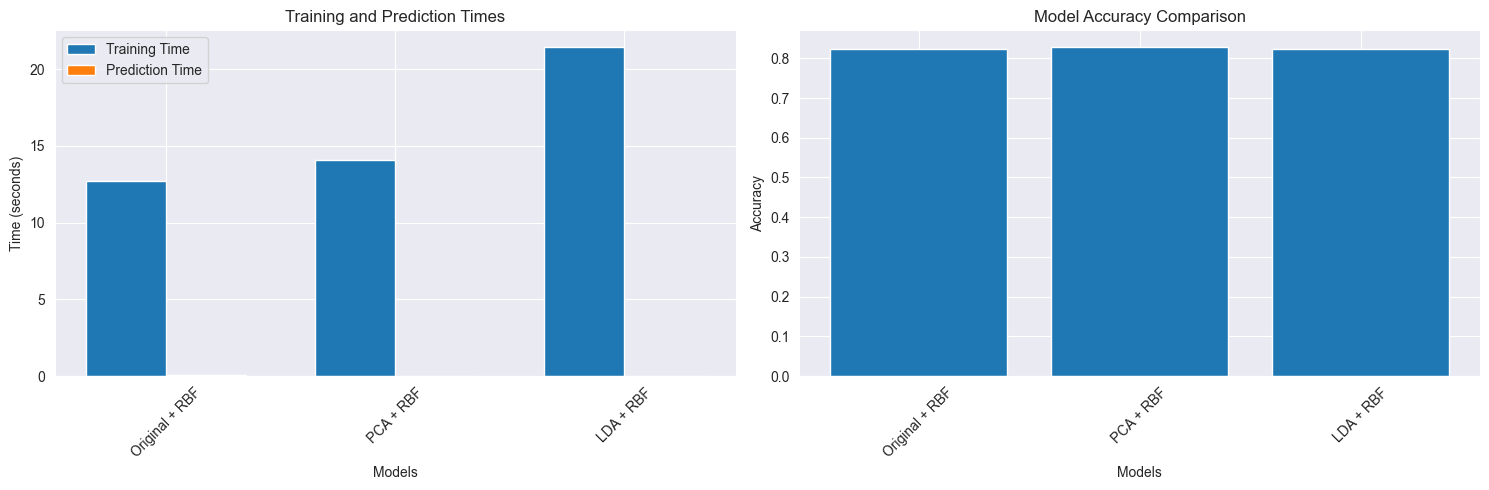

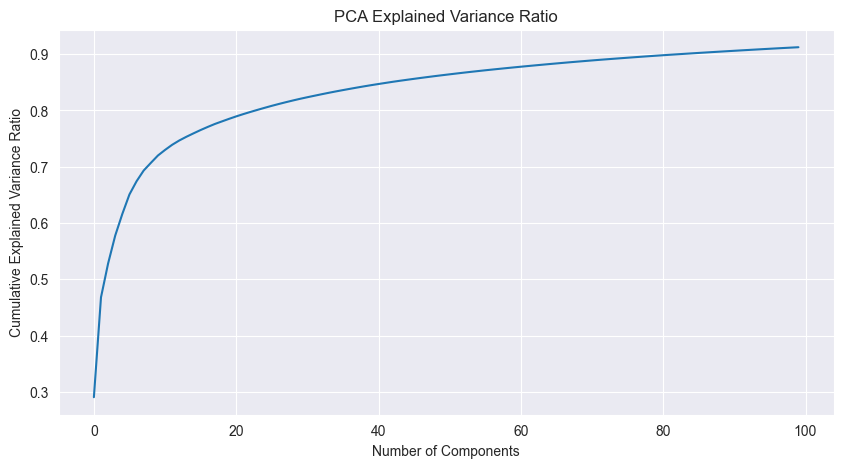


Detailed Analysis:
--------------------------------------------------

Original + RBF:
- Training Time: 12.6963 seconds
- Prediction Time: 0.0741 seconds
- Total Time: 12.7704 seconds
- Accuracy: 0.8226

PCA + RBF:
- Training Time: 14.1024 seconds
- Prediction Time: 0.0286 seconds
- Total Time: 14.1310 seconds
- Accuracy: 0.8287

LDA + RBF:
- Training Time: 21.4495 seconds
- Prediction Time: 0.0261 seconds
- Total Time: 21.4756 seconds
- Accuracy: 0.8244

PCA Additional Information:
- Number of components: 100
- Explained variance ratio sum: 0.9123
- Original dimensionality: 784
- Reduced dimensionality: 100

LDA Additional Information:
- Number of components: 9
- Original dimensionality: 784
- Reduced dimensionality: 9

Classification Reports:

Original Data + RBF:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.98      0.95      0.96      1000
           2       0.71      0.71      0.71      1000
     

In [20]:
# Presetting the number of components
n_components_pca = 100
n_components_lda = 9  # LDA defined by max(classes) - 1
n_components_nystroem = 100

results = {
    'Model': [],
    'Training Time': [],
    'Prediction Time': [],
    'Accuracy': []
}

# 1. Original data with RBF kernel (Nystroem + LinearSVC)
print("\nTraining RBF Kernel SVM on original data...")
pipeline_original = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', 
                         random_state=42, 
                         n_components=n_components_nystroem)),
    ('linear_svc', LinearSVC(dual='auto', random_state=42))
])

start_time = time.time()
pipeline_original.fit(X_train, y_train)
train_time_original = time.time() - start_time

start_time = time.time()
y_pred_original = pipeline_original.predict(X_test)
predict_time_original = time.time() - start_time

results['Model'].append('Original + RBF')
results['Training Time'].append(train_time_original)
results['Prediction Time'].append(predict_time_original)
results['Accuracy'].append(accuracy_score(y_test, y_pred_original))

# 2. PCA + RBF kernel (Nystroem + LinearSVC)
print("\nApplying PCA...")
start_time = time.time()
pca = PCA(n_components=n_components_pca)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca_transform_time = time.time() - start_time

print("\nTraining RBF Kernel SVM on PCA transformed data...")
pipeline_pca = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', 
                         random_state=42, 
                         n_components=n_components_nystroem)),
    ('linear_svc', LinearSVC(dual='auto', random_state=42))
])

start_time = time.time()
pipeline_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time

start_time = time.time()
y_pred_pca = pipeline_pca.predict(X_test_pca)
predict_time_pca = time.time() - start_time

results['Model'].append(f'PCA + RBF')
results['Training Time'].append(train_time_pca + pca_transform_time)
results['Prediction Time'].append(predict_time_pca)
results['Accuracy'].append(accuracy_score(y_test, y_pred_pca))

# 3. LDA + RBF kernel (Nystroem + LinearSVC)
print("\nApplying LDA...")
start_time = time.time()
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
lda_transform_time = time.time() - start_time

print("\nTraining RBF Kernel SVM on LDA transformed data...")
pipeline_lda = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', 
                         random_state=42, 
                         n_components=n_components_nystroem)),
    ('linear_svc', LinearSVC(dual='auto', random_state=42))
])

start_time = time.time()
pipeline_lda.fit(X_train_lda, y_train)
train_time_lda = time.time() - start_time

start_time = time.time()
y_pred_lda = pipeline_lda.predict(X_test_lda)
predict_time_lda = time.time() - start_time

results['Model'].append(f'LDA + RBF')
results['Training Time'].append(train_time_lda + lda_transform_time)
results['Prediction Time'].append(predict_time_lda)
results['Accuracy'].append(accuracy_score(y_test, y_pred_lda))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['Total Time'] = results_df['Training Time'] + results_df['Prediction Time']

# Print results
print("\nPerformance Comparison:")
print(results_df.round(4))

# Visualization
plt.figure(figsize=(15, 5))

# 1. Time comparison
plt.subplot(1, 2, 1)
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, results_df['Training Time'], width, label='Training Time')
plt.bar(x + width/2, results_df['Prediction Time'], width, label='Prediction Time')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Training and Prediction Times')
plt.xticks(x, models, rotation=45)
plt.legend()

# 2. Accuracy comparison
plt.subplot(1, 2, 2)
plt.bar(models, results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot PCA explained variance ratio
plt.figure(figsize=(10, 5))
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()


# Print detailed analysis
print("\nDetailed Analysis:")
print("-" * 50)
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"- Training Time: {row['Training Time']:.4f} seconds")
    print(f"- Prediction Time: {row['Prediction Time']:.4f} seconds")
    print(f"- Total Time: {row['Total Time']:.4f} seconds")
    print(f"- Accuracy: {row['Accuracy']:.4f}")

# For PCA specifically
print("\nPCA Additional Information:")
print(f"- Number of components: {n_components_pca}")
print(f"- Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"- Original dimensionality: {X_train.shape[1]}")
print(f"- Reduced dimensionality: {X_train_pca.shape[1]}")

# For LDA specifically
print("\nLDA Additional Information:")
print(f"- Number of components: {n_components_lda}")
print(f"- Original dimensionality: {X_train.shape[1]}")
print(f"- Reduced dimensionality: {X_train_lda.shape[1]}")

# Classification Reports
print("\nClassification Reports:")
print("\nOriginal Data + RBF:")
print(classification_report(y_test, y_pred_original))

print("\nPCA + RBF:")
print(classification_report(y_test, y_pred_pca))

print("\nLDA + RBF:")
print(classification_report(y_test, y_pred_lda))

## Conclusion: Curse of Dimensionality

The code above provides a practical example of the "curse of dimensionality" in machine learning. As demonstrated, high-dimensional data (such as the original 784-feature MNIST dataset) can complicate model training, affecting both computational efficiency and prediction accuracy. Dimensionality reduction techniques like PCA (Principal Component Analysis) and LDA (Linear Discriminant Analysis) are employed to mitigate this issue by reducing the data to a smaller set of features.

### Key Observations and Insights:
1. **Training and Prediction Time**: Reducing dimensions with PCA and LDA leads to faster training and prediction times compared to using the full 784 features. This confirms that as dimensionality increases, computational requirements grow substantially, resulting in longer processing times. By reducing the number of features, models can operate more efficiently without necessarily compromising accuracy.

2. **Model Accuracy**: Despite the reduction in feature space, the model's accuracy does not degrade significantly when using PCA or LDA. In fact, PCA with 100 components captures a significant amount of variance, retaining critical information while reducing dimensionality. LDA, which is more sensitive to class separability, also provides an effective feature reduction strategy by focusing on dimensions that maximize class distinctions.

3. **Effectiveness of Kernel Approximation**: Using kernel approximation (Nystroem) with the RBF kernel in combination with dimensionality reduction shows that even complex models can perform well with fewer features. This further supports the idea that high-dimensional data can often be reduced to a more manageable number of features without a significant loss in performance.

### Conclusion
The code illustrates that the curse of dimensionality can indeed be alleviated through dimensionality reduction techniques like PCA and LDA. High-dimensional data can lead to increased computational costs and, in some cases, decreased model performance due to overfitting or sparsity issues. Reducing the dimensionality allows for faster processing, often without substantial loss in accuracy, underscoring the importance of selecting an appropriate number of dimensions to balance efficiency and predictive power.
